# Hugging Face - Named entity recognition (NER) in Japanese

*back to [index](https://github.com/tsmatz/huggingface-finetune-japanese/)*

## Install required packages

In [ ]:
!pip install numpy seqeval pandas matplotlib scikit-learn

## Check device

Check whether GPU is available.

In [1]:
import torch

if torch.cuda.is_available():
    print("GPU is enabled.")
    print("device count: {}, current device: {}".format(torch.cuda.device_count(), torch.cuda.current_device()))
else:
    print("GPU is not enabled.")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

GPU is enabled.
device count: 1, current device: 0


## Prepare data

In this example, we use Wikipedia Japanese NER dataset by Stockmark Inc.<br>
Please download ```ner.json``` from [here](https://github.com/stockmarkteam/ner-wikipedia-dataset), and load data.

In [ ]:
##### When you use PAN-X.ja, please use below
# from collections import defaultdict
# from datasets import load_dataset, DatasetDict
# panx_ch = defaultdict(DatasetDict)
# ds = load_dataset("xtreme", name="PAN-X.ja")

In [2]:
import json

with open("ner.json") as f:
    json_all = json.load(f)

Create HuggingFace dataset.

In [3]:
from datasets import Dataset, Features, Sequence, Value, ClassLabel

tokens_list = []
ner_tags_list = []
for json_dat in json_all:
    tokens = list(json_dat["text"])
    ner_tags = ["O"] * len(tokens)
    for ent in json_dat["entities"]:
        for i in range(ent["span"][0], ent["span"][1]):
            # See https://github.com/stockmarkteam/ner-wikipedia-dataset
            if ent["type"] == "人名":  # person
                ner_tags[i] = "PER"
            elif ent["type"] == "法人名":  # organization (corporation general)
                ner_tags[i] = "ORG"
            elif ent["type"] == "政治的組織名":  # organization (political)
                ner_tags[i] = "ORG-P"
            elif ent["type"] == "その他の組織名":  # organization (others)
                ner_tags[i] = "ORG-O"
            elif ent["type"] == "地名":  # location
                ner_tags[i] = "LOC"
            elif ent["type"] == "施設名":  # institution (facility)
                ner_tags[i] = "INS"
            elif ent["type"] == "製品名":  # product
                ner_tags[i] = "PRD"
            elif ent["type"] == "イベント名":  # event
                ner_tags[i] = "EVT"
    tokens_list.append(tokens)
    ner_tags_list.append(ner_tags)

features = Features({
    "tokens": Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
    "ner_tags": Sequence(feature=ClassLabel(names=["O", "PER", "ORG", "ORG-P", "ORG-O", "LOC", "INS", "PRD", "EVT"], id=None), length=-1, id=None)
})
ds = Dataset.from_dict(
    {"tokens": tokens_list, "ner_tags": ner_tags_list},
    features=features
)
ds

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


Dataset({
    features: ['tokens', 'ner_tags'],
    num_rows: 5343
})

Split dataset into train and validation.

In [4]:
ds = ds.train_test_split(test_size=0.1, shuffle=True)
ds

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 4808
    })
    test: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 535
    })
})

The ```ner_tags``` feature are labeled by ```ClassLabel``` index.

In [5]:
tags = ds["train"].features["ner_tags"].feature
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}
tags

ClassLabel(names=['O', 'PER', 'ORG', 'ORG-P', 'ORG-O', 'LOC', 'INS', 'PRD', 'EVT'], id=None)

See tokens in original dataset.<br>
You will find that it's now tokenized in each character.

In [6]:
import pandas as pd

pd.DataFrame(
    [ds["train"][0]["tokens"], ds["train"][0]["ner_tags"]],
    index=["tokens", "ner_tags"])

,0,1,2,3,4,5,6,7,8,9,...,49,50,51,52,53,54,55,56,57,58
tokens,名,誉,革,命,に,よ,る,ヴ,ォ,ー,...,た,こ,と,が,挙,げ,ら,れ,る,。
ner_tags,8,8,8,8,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0


Load tokenizer in pre-trained ```xlm-roberta-base``` model. (Tokenizer is not trained.)

In [7]:
from transformers import AutoTokenizer

xlmr_tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")

Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

See how text is tokenized with this tokenizer.<br>
You will find that it's tokenized with words. We should then convertcharacter-based tokens (which is current format in dataset) into word-based tokens.

In [8]:
test_encoding = xlmr_tokenizer("".join(ds["train"]["tokens"][0]))
pd.DataFrame(
    [xlmr_tokenizer.convert_ids_to_tokens(test_encoding.input_ids)],
    index=["tokens"])

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
tokens,<s>,▁,名,誉,革命,による,ヴ,ォ,ーン,の影響,...,る,ぎ,ない,もの,にした,ことが,挙げ,られる,。,</s>


Convert character-based tokens into word-based tokens as follows.<br>
Labels are also converted into the corresponding tokens.

<ins>dataset tokens</ins>

| | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 |
| ---------- | -- | -- | -- | -- | -- | -- | -- | -- |
| **Tokens** | 松 | 崎 | は | 日 | 本 | に | い | る |
| **Tags**   | PER | PER | O | LOC | LOC | O | O | O |

<ins>required tokens in this model</ins>

| | 0 | 1 | 2 | 3 | 4 | 5 | 6 |
| ---------- | -- | -- |-- |-- |-- |-- |-- |
| **Tokens** | ▁ | 松 | 崎 | は | 日本 | に | いる |
| **Tags**   | PER | PER | PER | O | LOC | O | O |

In [9]:
#
# See https://huggingface.co/docs/transformers/main_classes/tokenizer#transformers.BatchEncoding
#

import numpy as np

def tokenize_and_align_labels(data):
    text = ["".join(t) for t in data["tokens"]]
    # tokenized_inputs = xlmr_tokenizer(text, truncation=True, max_length=512)
    tokenized_inputs = xlmr_tokenizer(text)

    #
    # map label to the new token
    #
    # [example]
    #   org token (data)            : ["松", "崎", "は", "日", "本", "に", "い", "る"]
    #   new token (tokenized_inputs): ["_", "松", "崎", "は", "日本", "に", "いる"]
    labels = []
    for row_idx, label_old in enumerate(data["ner_tags"]):
        # label is initialized as [[], [], [], [], [], [], []]
        label_new = [[] for t in tokenized_inputs.tokens(batch_index=row_idx)]
        # label becomes [[1], [1], [1], [0], [5, 5], [0], [0, 0]]
        for char_idx in range(len(data["tokens"][row_idx])):
            token_idx = tokenized_inputs.char_to_token(row_idx, char_idx)
            if token_idx is not None:
                label_new[token_idx].append(data["ner_tags"][row_idx][char_idx])
                if (tokenized_inputs.tokens(batch_index=row_idx)[token_idx] == "▁") and (data["ner_tags"][row_idx][char_idx] != 0):
                    label_new[token_idx+1].append(data["ner_tags"][row_idx][char_idx])
        # label becomes [1, 1, 1, 0, 5, 0, 0]
        label_new = list(map(lambda i : max(i, default=0), label_new))
        # append result
        labels.append(label_new)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [10]:
tokenized_ds = ds.map(
    tokenize_and_align_labels,
    remove_columns=["tokens", "ner_tags"],
    batched=True,
    batch_size=128)

  0%|          | 0/38 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

In [11]:
pd.DataFrame(
    [xlmr_tokenizer.convert_ids_to_tokens(tokenized_ds["train"][0]["input_ids"]), tokenized_ds["train"][0]["labels"]],
    index=["tokens", "ner_tags"])

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
tokens,<s>,▁,名,誉,革命,による,ヴ,ォ,ーン,の影響,...,る,ぎ,ない,もの,にした,ことが,挙げ,られる,。,</s>
ner_tags,0,8,8,8,8,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
#shuffled_tokenized_ds = tokenized_ds.shuffle()

When data is so large, please save this dataset in disk and load dataset directly from file. (HuggingFace dataset then uses memory-mapped file.)<br>
In this example, we use pre-processed dataset in memory.

## Fine-tune

We prepare training arguments for fine-tune.<br>
In this example, we use HuggingFace transformer trainer class, with which you can run training without manually writing training loop.

In [12]:
%env TOKENIZERS_PARALLELISM=false

env: TOKENIZERS_PARALLELISM=false


First we prepare trainer's arguments.<br>
The checkpoint file is saved in the folder named ```xlm-roberta-ner-ja```.

> Note : This will require a lot of disk space, because the model is large. Please check whether you have enough space.

In [13]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir = "xlm-roberta-ner-ja",
    log_level = "error",
    num_train_epochs = 1,
    per_device_train_batch_size = 12,
    per_device_eval_batch_size = 12,
    evaluation_strategy = "epoch",
    fp16 = True,
    logging_steps = len(tokenized_ds["train"]),
    push_to_hub = False
)

We also prepare metrics function for evaluation in the training.

In this example, we will use ```DataCollatorForTokenClassification``` for data collator (pre-processing data), and the padded label id will become -100 by this data collator. (See [document](https://huggingface.co/docs/transformers/main_classes/data_collator) for data collator.)<br>
Therefore -100 is ignored in evaluation as follows.

In [14]:
import numpy as np
# see https://huggingface.co/spaces/evaluate-metric/seqeval
from seqeval.metrics import f1_score

def metrics_func(eval_arg):
    preds = np.argmax(eval_arg.predictions, axis=2)
    batch_size, seq_len = preds.shape
    y_true, y_pred = [], []
    for b in range(batch_size):
        true_label, pred_label = [], []
        for s in range(seq_len):
            if eval_arg.label_ids[b, s] != -100:  # -100 must be ignored
                true_label.append(index2tag[eval_arg.label_ids[b][s]])
                pred_label.append(index2tag[preds[b][s]])
        y_true.append(true_label)
        y_pred.append(pred_label)
    return {"f1": f1_score(y_true, y_pred)}

We also prepare data collator, which will pre-process data.

As I have mentioned above, the classification data collator class (```DataCollatorForTokenClassification```) will also apply padding to the longest sequence in the batch and the padded token will be filled with label id -100 by default.<br>
This token will then be ignored in loss computation and evaluation.

In [15]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(
    xlmr_tokenizer,
    return_tensors="pt")

Build trainer. (Put it all together.)

Here we use ```RobertaForTokenClassification``` model. This model consists of pre-trained ```RobertaModel``` with classification head (subsequent dropout and linear layer).<br>
See [here](https://github.com/huggingface/transformers/blob/main/src/transformers/models/roberta/modeling_roberta.py) for the source code.

In [16]:
from transformers import AutoConfig, Trainer
from transformers.models.roberta.modeling_roberta import RobertaForTokenClassification

xlmr_config = AutoConfig.from_pretrained(
    "xlm-roberta-base",
    num_labels=tags.num_classes,
    id2label=index2tag,
    label2id=tag2index
)
model = (RobertaForTokenClassification
         .from_pretrained("xlm-roberta-base", config=xlmr_config)
         .to(device))

trainer = Trainer(
    model = model,
    args = training_args,
    data_collator = data_collator,
    compute_metrics = metrics_func,
    train_dataset = tokenized_ds["train"],
    eval_dataset = tokenized_ds["test"],
    tokenizer = xlmr_tokenizer
)

Downloading:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing RobertaForTokenClassification: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to

[Optional] You can also test the model which is not trained for NER. 

In [ ]:
# model(xlmr_tokenizer.encode("Jack Sparrow loves New York !", return_tensors="pt").to(device)).logits

Now let's run training.

In [17]:
trainer.train()

/home/tsmatsuz/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,No log,0.140325,0.893241


/home/tsmatsuz/.local/lib/python3.8/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ORG-P seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/tsmatsuz/.local/lib/python3.8/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: LOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/tsmatsuz/.local/lib/python3.8/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PER seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/tsmatsuz/.local/lib/python3.8/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ORG seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/tsmatsuz/.local/lib/python3.8/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: INS seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/tsmatsuz/.local/lib/python3

TrainOutput(global_step=401, training_loss=0.39201328344178615, metrics={'train_runtime': 373.4648, 'train_samples_per_second': 12.874, 'train_steps_per_second': 1.074, 'total_flos': 194856014896488.0, 'train_loss': 0.39201328344178615, 'epoch': 1.0})

In order to use it later, you can save the trained model.

In [18]:
import os

os.makedirs("./trained_ner_classifier_jp", exist_ok=True)
#trainer.save_model("./trained_ner_classifier_jp")
if hasattr(trainer.model, "module"):
    trainer.model.module.save_pretrained("./trained_ner_classifier_jp")
else:
    trainer.model.save_pretrained("./trained_ner_classifier_jp")

Load pre-trained model from local.

In [19]:
import torch
from transformers import AutoConfig

xlmr_config = AutoConfig.from_pretrained(
    "xlm-roberta-base",
    num_labels=tags.num_classes,
    id2label=index2tag,
    label2id=tag2index
)
model = (RobertaForTokenClassification
         .from_pretrained("./trained_ner_classifier_jp", config=xlmr_config)
         .to(device))

## Predict

Now let's see how it works with pre-trained model.

As you can see below, the first word of "中国" (="China") is recognized as a location name, but the second word of "中国" (China) in "中国共産党" (Communist Party of China) is recognized as an organization name. Also, "共産党" (Communist Party) is recognized as an organization, but "一党" (one party) is not recognized as an organization.

> Note : You can also use ```predict()``` method in Trainer class.

In [20]:
from datasets import Dataset

sample_encoding = xlmr_tokenizer([
    "鈴木は4月の陽気の良い日に、鈴をつけて熊本県の阿蘇山に登った",
    "中国では、中国共産党による一党統治が続く",
], truncation=True, max_length=512)
sample_dataset = Dataset.from_dict(sample_encoding)
sample_dataset = sample_dataset.with_format("torch")

In [21]:
import torch
from torch.utils.data import DataLoader

sample_dataloader = DataLoader(sample_dataset, batch_size=1)
tokens = []
labels = []
for batch in sample_dataloader:
    # predict
    with torch.no_grad():
        output = model(batch["input_ids"].to(device), batch["attention_mask"].to(device))
    predicted_label_id = torch.argmax(output.logits, axis=-1).cpu().numpy()
    # create output
    tokens.append(xlmr_tokenizer.convert_ids_to_tokens(batch["input_ids"][0]))
    labels.append([index2tag[i] for i in predicted_label_id[0]])

In [22]:
import pandas as pd

pd.DataFrame([tokens[0], labels[0]], index=["Tokens", "Tags"])

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Tokens,<s>,▁,鈴,木,は,4,月の,陽,気,の良い,...,熊本,県,の,阿,蘇,山,に,登,った,</s>
Tags,O,PER,PER,PER,O,O,O,O,O,O,...,LOC,LOC,O,LOC,LOC,LOC,O,O,O,O


In [23]:
pd.DataFrame([tokens[1], labels[1]], index=["Tokens", "Tags"])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Tokens,<s>,▁中国,では,、,中国,共,産,党,による,一,党,統治,が,続く,</s>
Tags,O,LOC,O,O,ORG-P,ORG-P,ORG-P,ORG-P,O,O,O,O,O,O,O


## Analyze errors

Let's run inference with test dataset, and analyze the results.<br>
As you can see below, a lot of "```PER```" (person name) has incorrectly classified as "```ORG-O```" (other organization name), since it's difficult to classify these names in Japanese.

In [24]:
from torch.nn.functional import cross_entropy

def process_test(batch):
    # process data collator
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    new_batch = data_collator(features)
    # run inference (prediction)
    with torch.no_grad():
        input_ids = new_batch["input_ids"].to(device)
        attention_mask = new_batch["attention_mask"].to(device)
        output = model(input_ids, attention_mask)
        predicted_label_id = torch.argmax(output.logits, axis=-1).cpu().numpy()
    # compute loss (but we won't use this result)
    true_label_id = new_batch["labels"].to(device)
    loss = cross_entropy(
        output.logits.view(-1, tags.num_classes),
        true_label_id.view(-1),
        reduction="none"
    )
    loss = loss.view(len(input_ids), -1).cpu().numpy()
    # create output
    return {
        "loss": loss,
        "predicted_labels": predicted_label_id
    }

test_dataset = tokenized_ds["test"]
test_output = test_dataset.map(process_test, batched=True, batch_size=32)
test_output_df = test_output.to_pandas()

  0%|          | 0/17 [00:00<?, ?ba/s]

In [25]:
test_output_df["label_tags"] = test_output_df["labels"].apply(
    lambda row: [index2tag[i] for i in row])
test_output_df["predicted_label_tags"] = test_output_df[["predicted_labels", "attention_mask"]].apply(
    lambda row: [index2tag[i] for i in row.predicted_labels][:len(row.attention_mask)], axis = 1)

In [26]:
test_output_df

,input_ids,attention_mask,labels,loss,predicted_labels,label_tags,predicted_label_tags
0,"[0, 6, 185755, 50456, 919, 154, 2954, 13080, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0024523442, 0.0016349294, 0.0010371788, 0.3...","[0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, ...","[O, O, O, ORG-P, ORG-P, O, O, O, O, O, O, O, O...","[O, O, O, ORG-P, ORG-P, O, O, O, O, O, O, ORG-..."
1,"[0, 6, 55422, 31560, 14577, 14323, 6242, 4441,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 5, 5, 5, 5, 5, 5, 0, 1, 1, 0, 0, 0, 0, 0, ...","[0.0019601434, 5.0906296, 5.201472, 5.3190703,...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ...","[O, LOC, LOC, LOC, LOC, LOC, LOC, O, PER, PER,...","[O, PER, PER, PER, PER, PER, PER, PER, PER, PE..."
2,"[0, 6, 9501, 10045, 217417, 6808, 154, 55422, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0032714678, 0.019455321, 0.016702574, 0.016...","[0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[O, ORG, ORG, ORG, ORG, ORG, O, O, O, O, O, O,...","[O, ORG, ORG, ORG, ORG, ORG, O, O, O, O, O, O,..."
3,"[0, 15974, 37, 3230, 19705, 281, 192783, 1925,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0015376898, 0.0008931938, 0.0006227938, 0.0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
4,"[0, 6, 27932, 10045, 37023, 17462, 31814, 4138...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 6, 6, 6, 6, 6, 6, 0, 1, 1, 1, 1, 1, ...","[0.0017930873, 0.0027236769, 0.0012497242, 0.3...","[0, 0, 0, 6, 6, 6, 6, 6, 6, 0, 3, 1, 1, 1, 1, ...","[O, O, O, INS, INS, INS, INS, INS, INS, O, PER...","[O, O, O, INS, INS, INS, INS, INS, INS, O, ORG..."
...,...,...,...,...,...,...,...
530,"[0, 3691, 3752, 5139, 22503, 8779, 140430, 209...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 0, 0, 0, ...","[0.0027869216, 0.0069671785, 0.027065467, 0.02...","[0, 0, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 0, 0, 0, ...","[O, O, PRD, PRD, PRD, PRD, PRD, PRD, PRD, PRD,...","[O, O, PRD, PRD, PRD, PRD, PRD, PRD, PRD, PRD,..."
531,"[0, 6, 65322, 37, 2150, 20119, 5291, 2283, 302...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, ...","[0.001760482, 0.0023461455, 0.001756436, 0.002...","[0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, ...","[O, O, O, O, ORG-P, ORG-P, ORG-P, ORG-P, ORG-P...","[O, O, O, O, ORG-P, ORG-P, ORG-P, ORG-P, ORG-P..."
532,"[0, 6, 116673, 154, 155313, 575, 37, 46900, 38...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0.0021935469, 0.004627472, 0.0031695152, 0.00...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
533,"[0, 6, 40247, 1147, 22899, 47051, 37, 41215, 9...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.002543074, 0.045256536, 0.046741482, 0.0569...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


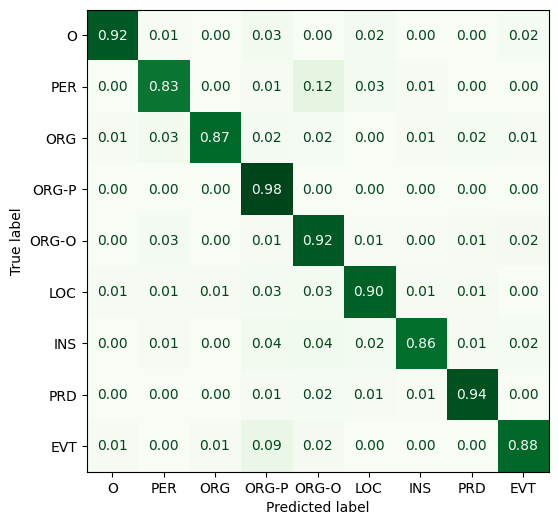

In [27]:
from itertools import chain
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

conf_matrix = confusion_matrix(
    list(chain.from_iterable(test_output_df["label_tags"])),
    list(chain.from_iterable(test_output_df["predicted_label_tags"])),
    normalize="true")
fig, ax = plt.subplots(figsize=(6, 6))
conf_display = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix,
    display_labels=tags.names)
conf_display.plot(cmap="Greens", values_format=".2f", ax=ax, colorbar=False)
plt.show()